<a href="https://colab.research.google.com/github/Nima-Nilchian/Keyword_extraction/blob/master/Keyword_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keyword Extraction

# استخراج عبارت‌های کلیدی متن

<p align="right">
ارزیابی روش‌ها مورد استفاده قرار خواهد گرفت. علاوه بر گزارش نتایج برای هر یک از روش‌ها با استفاده از مجموعه داده، نمونه‌هایی از خروجی را هم برای هر روش گزارش کرده و به صورت شهودی نیز مقایسه‌ای انجام دهید. همچنین سرعت روش‌های پیاده‌سازی شده نیز نیاز به مقایسه دارد.
</p>
<p align="right">
:روش‌های زیر را پیاده‌سازی و طبق روال بالا ارزیابی و مقایسه کنید
</p>

*   baseline (TF-IDF)
*   TF-IDF with Ngrams
*   TF-IDF with chunking
*   KP-Miner
*   Yake
*   TextRank
*   SingleRank
*   TopicRank
*   TopicalPageRank
*   PositionRank
*   MultipartiteRank
*   scake
*   sgrank











# Reading and preproccessing Data

In [ ]:
!pip install git+https://github.com/boudinfl/pke.git
!pip install perke
!python -m perke download
!pip install yake
!pip install keybert

In [1]:
import numpy as np
import pandas as pd
import json
import string
import re
import time
from hazm import *
import nltk

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount("./content")

Mounted at ./content


In [4]:
data_loc = './content/MyDrive/datasets/ke/ke_dataset.txt'

df = pd.DataFrame()
with open(data_loc, 'r') as f:
  for line in f.readlines():
    json_data = json.loads(line.strip())
    df = pd.concat([df, pd.DataFrame([json_data])], ignore_index=True)

df.drop('id', axis=1, inplace=True)
all_texts = df['body'].tolist()

In [ ]:
exist_keywords = []
c = 0
for i in range(len(df)):
  keywords = [k for k in df.keywords.iloc[i] if k in df.body.iloc[i]]
  exist_keywords.append(keywords)

# df['existing_keywords'] = exist_keywords
# df

In [5]:
stopwords = stopwords_list() + ['ها', 'های', 'ی']

normalizer = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()

tagger = POSTagger(model='./content/MyDrive/resources/pos_tagger.model', universal_tag=False)

def preprocess(stemming=True, lemmatizing=False, reg_clean=False, tagging=True, remove_stopwords=True):
  df['clean_text'] = df['body'].apply(lambda sample: normalizer.normalize(sample))

  if reg_clean:
    df['clean_text'] = df['clean_text'].apply(lambda sample: re.sub(r"[^\w\s]", ' ', sample))
    df['clean_text'] = df['clean_text'].apply(lambda sample: re.sub(r"\d", ' ', sample))
    df['clean_text'] = df['clean_text'].apply(lambda sample: re.sub(r"\s+", ' ', sample))

  if tagging:
    df["clean_text"] = df["clean_text"].apply(lambda sample: sent_pos_tagg(sample))
  else:
    df["clean_text"] = df["clean_text"].apply(lambda r: [w for w in word_tokenize(r)])

  if remove_stopwords:
    df['clean_text'] = df["clean_text"].apply(lambda sample:[word for word in sample
                                                          if word not in stopwords and len(word) > 1
                                                          and not word.isdigit()])
  if stemming:
    df['clean_text'] = df['clean_text'].apply(lambda sample:[stemmer.stem(word)
                                                            for word in sample])
  if lemmatizing:
    df['clean_text'] = df['clean_text'].apply(lambda sample:[lemmatizer.lemmatize(word)
                                                            for word in sample])

  clean_text = df.clean_text.values.tolist()
  train_data = [' '.join(word for word in text).strip() for text in clean_text]
  df.drop(columns='clean_text', inplace=True)

  return train_data


def sent_pos_tagg(text):
  sent_pos = tagger.tag_sents(word_tokenize(sent) for sent in sent_tokenize(text))
  sent_pos_flat = [item for sent in sent_pos for item in sent]
  tokens = []
  for pos in sent_pos_flat:
    if pos[1] in ['NOUN', 'ADJ', 'NOUN,EZ', 'ADJ,EZ']:
      tokens.append(pos[0])

  return tokens


# Metrics

first we evaluated models with f1-score

In [6]:
def evaluate(candidates, references, ngrams_=False):
    if len(references) == 0:
      return 0.5

    new_references = references
    if ngrams_:
      new_references = references + ngrams(references)

    r = len(set(new_references) & set(candidates)) / len(set(references))
    p = len(set(new_references) & set(candidates)) / len(set(candidates))

    if p == 0 or r == 0:
      return [0, 0, 0]

    return [(2*p*r) / (p+r), r, p]


In [7]:
""" extract ngrams(2, 3) from reference keywords so the f1 score calculation
    will have more matches
"""
def ngrams(ref):
  new_ref = set()
  for word in ref:
    word_splits = word.split()

    if len(word_splits) > 3:
      for i in range(len(word_splits) - 2):
        new_ref.add(' '.join(word_splits[i:i+3]))

    elif len(word_splits) > 2:
      for i in range(len(word_splits) - 1):
        new_ref.add(' '.join(word_splits[i:i+2]))

    else:
      new_ref.add(word)

  return list(new_ref)

In [ ]:
# Example
rf = df.keywords.iloc[0]
print("references: ", rf)
print("ngram references: ", ngrams(rf))

references:  ['فقه الحدیث', 'معانی الاخبار', 'روش فقه الحدیثی', 'چینش هندسی روایات', 'شیخ صدوق', 'مبانی فقه الحدیثی']
ngram references:  ['چینش هندسی', 'مبانی فقه', 'معانی الاخبار', 'روش فقه', 'شیخ صدوق', 'فقه الحدیث', 'هندسی روایات', 'فقه الحدیثی']


# Models and algorithm implementations

## TF-IDF

iamfakfd

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

stopwords = stopwords_list() + ['ها', 'های', 'ی']

vectorizer_without_ngram = TfidfVectorizer(ngram_range=(1,1), tokenizer=word_tokenize,
                                           stop_words=stopwords, analyzer='word')

vectorizer = TfidfVectorizer(ngram_range=(1, 5), min_df=0.01, tokenizer=word_tokenize,
                             stop_words=stopwords, analyzer='word')

In [ ]:
def tfidf_extractor(texts, top=10, vectorizer=vectorizer):
  candids = []
  for text in texts:
    X = vectorizer.fit_transform([text])

    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = X.toarray().sum(axis=0)

    top_keywords = sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1],
                          reverse=True)[:top]
    keyword, score = zip(*top_keywords)
    candids.append(list(keyword))

  return candids

In [ ]:
# Preprocessed Texts
with_chunking = preprocess(stemming=False, lemmatizing=False, reg_clean=False, tagging=True, remove_stopwords=True)
without_chunking = preprocess(stemming=False, lemmatizing=False, reg_clean=False, tagging=False, remove_stopwords=True)

In [ ]:
num_keywords = 10

# baseline TF-IDF (no chunking and ngram)
candids_without_ngram = tfidf_extractor(without_chunking, num_keywords, vectorizer_without_ngram)
# TF-IDF with Ngram without chunking
candids_without_chunking = tfidf_extractor(without_chunking, num_keywords)
# TF-IDF with Ngram and chunking
candids_chunking = tfidf_extractor(with_chunking, num_keywords)

tfidf_score_without_ngram = []
tfidf_score_without_chunk = []
tfidf_score_chunk = []
tfidf_score_ngram_f1 = []

for i in range(len(candids_chunking)):
  tfidf_score_without_ngram.append(evaluate(without_chunking[i], df.keywords.iloc[i]))
  tfidf_score_without_chunk.append(evaluate(candids_without_chunking[i], df.keywords.iloc[i]))
  tfidf_score_chunk.append(evaluate(candids_chunking[i], df.keywords.iloc[i]))
  tfidf_score_ngram_f1.append(evaluate(candids_without_chunking[i], df.keywords.iloc[i], ngrams_=True))


# Normal f1 score evaluations
print(f'tfidf f1 score: without ngram: ', np.array(tfidf_score_without_ngram).mean(axis=0)[0])
print(f'tfidf f1 score: without chunking: ', np.round(np.array(tfidf_score_without_chunk).mean(axis=0)[0], 4))
print(f'tfidf f1 score: with chunking: ', np.round(np.array(tfidf_score_chunk).mean(axis=0)[0], 4))

# adding Ngram evaluation
print(f'tfidf f1 score: with chunking and not exact match references evaluation: ',
      np.round(np.array(tfidf_score_ngram_f1).mean(axis=0)[0], 4))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


tfidf f1 score: without ngram:  0.0
tfidf f1 score: without chunking:  0.1687
tfidf f1 score: with chunking:  0.1689
tfidf f1 score: with chunking and not exact match references evaluation:  0.2049


In [ ]:
num_keys = []
f1_scores, f1_scores_ngrams = [], []
recall_scores, recall_ngrams = [], []
percision_scores, percision_ngrams = [], []

for k in range(4, 15):
  tfidf_score = []
  tfidf_score_ngrams = []
  num_keys.append(k)
  candids = tfidf_extractor(with_chunking, k)
  for i in range(len(candids)):
    tfidf_score.append(evaluate(candids[i], df.keywords.iloc[i], ngrams_=False))
    tfidf_score_ngrams.append(evaluate(candids[i], df.keywords.iloc[i], ngrams_=True))

  scores = np.array(tfidf_score).mean(axis=0)
  f1_scores.append(scores[0])
  recall_scores.append(scores[1])
  percision_scores.append(scores[2])

  scores_ngrams = np.array(tfidf_score_ngrams).mean(axis=0)
  f1_scores_ngrams.append(scores_ngrams[0])
  recall_ngrams.append(scores_ngrams[1])
  percision_ngrams.append(scores_ngrams[2])

  print(f'tfidf f1 score with {k} keyword ', np.round(scores[0], 4))
  print(f'tfidf f1 score with {k} keyword not exact match evaluation',
        np.round(scores_ngrams[0], 4))


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


tfidf f1 score with 4 keyword  0.1232
tfidf f1 score with 4 keyword not exact match evaluation 0.1401
tfidf f1 score with 5 keyword  0.1357
tfidf f1 score with 5 keyword not exact match evaluation 0.1563
tfidf f1 score with 6 keyword  0.1486
tfidf f1 score with 6 keyword not exact match evaluation 0.1749
tfidf f1 score with 7 keyword  0.1579
tfidf f1 score with 7 keyword not exact match evaluation 0.1892
tfidf f1 score with 8 keyword  0.1622
tfidf f1 score with 8 keyword not exact match evaluation 0.1964
tfidf f1 score with 9 keyword  0.1682
tfidf f1 score with 9 keyword not exact match evaluation 0.2033
tfidf f1 score with 10 keyword  0.1689
tfidf f1 score with 10 keyword not exact match evaluation 0.2052
tfidf f1 score with 11 keyword  0.1686
tfidf f1 score with 11 keyword not exact match evaluation 0.2075
tfidf f1 score with 12 keyword  0.1692
tfidf f1 score with 12 keyword not exact match evaluation 0.2106
tfidf f1 score with 13 keyword  0.1689
tfidf f1 score with 13 keyword not ex

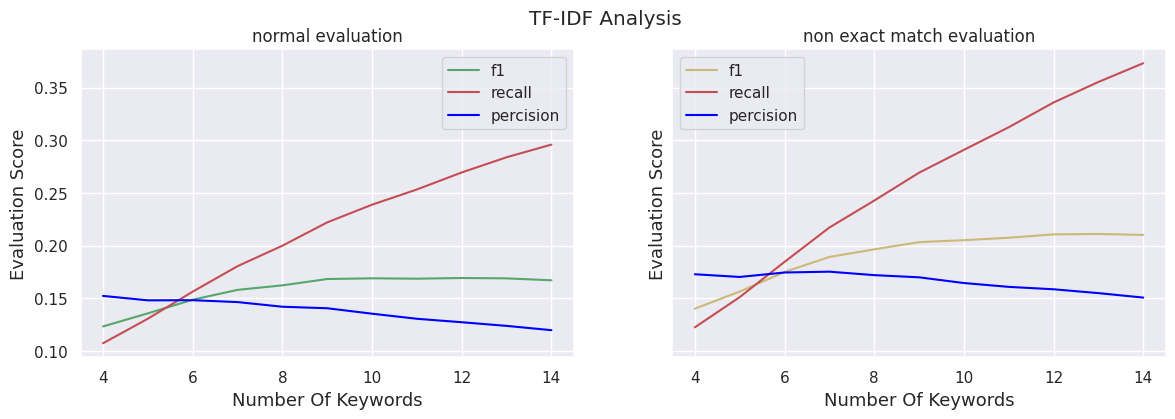

In [ ]:
fig , axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True, sharey=True)

fig.suptitle('TF-IDF Analysis')
axes[0].set_title('normal evaluation')
axes[0].set_xlabel('Number Of Keywords', fontsize=13)
axes[0].set_ylabel('Evaluation Score', fontsize=13)
axes[0].plot(num_keys, f1_scores, label = 'f1', color='g')
axes[0].plot(num_keys, recall_scores, label='recall', color='r')
axes[0].plot(num_keys, percision_scores, label='percision', color='blue')
axes[0].legend()

axes[1].set_title('non exact match evaluation')
axes[1].set_xlabel('Number Of Keywords', fontsize=13)
axes[1].set_ylabel('Evaluation Score', fontsize=13)
axes[1].plot(num_keys, f1_scores_ngrams, label='f1', color='y')
axes[1].plot(num_keys, recall_ngrams, label='recall', color='r')
axes[1].plot(num_keys, percision_ngrams, label='percision', color='blue')
axes[1].legend()




## PerKe Algorithms:

*   TopicRank:
*   TextRank:
*   SingleRank:
*   PositionRank:
*   MultipartiteRank:



In [ ]:
import multiprocessing
import perke

In [ ]:
def ke_topicRank(text):
  valid_pos_tags = {'NOUN', 'NOUN,EZ', 'ADJ', 'ADJ,EZ'}
  extractor = perke.unsupervised.graph_based.TopicRank()

  extractor.load_text(input=text, word_normalization_method=None)
  extractor.select_candidates()
  extractor.weight_candidates(
      threshold=0.67, metric='jaccard', linkage_method='average')

  keyphrases = extractor.get_n_best(n=10)
  candids, score = zip(*keyphrases)

  return list(candids)


def ke_textRank(text):
  valid_pos_tags = {'NOUN', 'NOUN,EZ', 'ADJ', 'ADJ,EZ'}
  extractor = perke.unsupervised.graph_based.TextRank()

  extractor.load_text(text, word_normalization_method=None)
  extractor.weight_candidates(window_size=3, top_t_percent=0.33)

  keyphrases = extractor.get_n_best(n=10)
  candids, score = zip(*keyphrases)

  return list(candids)


def ke_singleRank(text):
  valid_pos_tags = {'NOUN', 'NOUN,EZ', 'ADJ', 'ADJ,EZ'}
  extractor = perke.unsupervised.graph_based.SingleRank()

  extractor.load_text(input=text, word_normalization_method=None)
  extractor.select_candidates()
  extractor.weight_candidates(window=10)

  keyphrases = extractor.get_n_best(n=10)
  candids, score = zip(*keyphrases)

  return list(candids)


def ke_positionRank(text):
  # Define the grammar for selecting the keyphrase candidates
  grammar = r"""
      NP:
          {<NOUN>}<VERB>
      NP:
          {<DET(,EZ)?|NOUN(,EZ)?|NUM(,EZ)?|ADJ(,EZ)|PRON><DET(,EZ)|NOUN(,EZ)|NUM(,EZ)|ADJ(,EZ)|PRON>*}
          <NOUN>}{<.*(,EZ)?>
  """
  valid_pos_tags = {'NOUN', 'NOUN,EZ', 'ADJ', 'ADJ,EZ'}
  extractor = perke.unsupervised.graph_based.PositionRank()

  extractor.load_text(
      input=text, word_normalization_method=None,
      universal_pos_tags=False,
  )
  extractor.select_candidates(grammar=grammar, maximum_word_number=3)
  extractor.weight_candidates(window_size=10)

  keyphrases = extractor.get_n_best(n=10)
  candids, score = zip(*keyphrases)

  return list(candids)


def ke_multipartiteRank(text):
  valid_pos_tags = {'NOUN', 'NOUN,EZ', 'ADJ', 'ADJ,EZ'}
  extractor = perke.unsupervised.graph_based.MultipartiteRank()

  extractor.load_text(input=text, word_normalization_method=None)
  extractor.select_candidates()
  extractor.weight_candidates(
      threshold=0.70,
      metric='jaccard',
      linkage_method='average',
      alpha=1.2,
  )

  keyphrases = extractor.get_n_best(n=10)
  candids, score = zip(*keyphrases)

  return list(candids)

In [ ]:
# Number of processes to run in parallel
num_processes = multiprocessing.cpu_count()

# Create a multiprocessing pool
pool = multiprocessing.Pool(processes=num_processes)

s = time.time()
# Perform keyword extraction for each text using multiprocessing
results_topic = pool.map(ke_topicRank, all_texts[:25])
results_text = pool.map(ke_textRank, all_texts[:25])
results_single = pool.map(ke_singleRank, all_texts[:25])
results_position = pool.map(ke_positionRank, all_texts[:25])
results_multi = pool.map(ke_multipartiteRank, all_texts[:25])

e = time.time()
# Close the pool of processes
pool.close()
pool.join()
print('performance time: ', e - s)

In [ ]:
topicRank, topicRank_ngrams = [], []
textRank, textRank_ngrams= [], []
singleRank, singleRank_ngrams = [], []
positionRank, positionRank_ngrams = [], []
multi, multi_ngrams = [], []

for i in range(len(results_topic)):
  references = df['keywords'].iloc[i]
  topicRank.append(evaluate(results_topic[i], references))
  textRank.append(evaluate(results_text[i], references))
  singleRank.append(evaluate(results_single[i], references))
  positionRank.append(evaluate(results_position[i], references))
  multi.append(evaluate(results_multi[i], references))

  topicRank_ngrams.append(evaluate(results_topic[i], references, ngrams_=True))
  textRank_ngrams.append(evaluate(results_text[i], references, ngrams_=True))
  singleRank_ngrams.append(evaluate(results_single[i], references, ngrams_=True))
  positionRank_ngrams.append(evaluate(results_position[i], references, ngrams_=True))
  multi_ngrams.append(evaluate(results_multi[i], references, ngrams_=True))

print("Topic Rank mean f1 score is:", np.mean(np.array(topicRank), axis=0)[0].round(4))
print("Topic Rank f1 score non-exact match:", np.mean(np.array(topicRank_ngrams), axis=0)[0].round(4))
print()
print("Text Rank mean f1 score is:", np.mean(np.array(textRank), axis=0)[0].round(4))
print("Text Rank f1 score non-exact match: ", np.mean(np.array(textRank_ngrams), axis=0)[0].round(4))
print()
print("Single Rank mean f1 score is:", np.mean(np.array(singleRank), axis=0)[0].round(4))
print("Single Rank f1 score non-exact match:", np.mean(np.array(singleRank_ngrams), axis=0)[0].round(4))
print()
print("Position Rank mean f1 score is:", np.mean(np.array(positionRank), axis=0)[0].round(4))
print("Position Rank f1 score non-exact match:", np.mean(np.array(positionRank_ngrams), axis=0)[0].round(4))
print()
print("Multipartite Rank mean f1 score is:", np.mean(np.array(multi), axis=0)[0].round(4))
print("Multipartite Rank f1 score non-exact match:", np.mean(np.array(multi_ngrams), axis=0)[0].round(4))

Topic Rank mean f1 score is: 0.121
Topic Rank f1 score non-exact match: 0.121

Text Rank mean f1 score is: 0.1392
Text Rank f1 score non-exact match:  0.1631

Single Rank mean f1 score is: 0.0887
Single Rank f1 score non-exact match: 0.094

Position Rank mean f1 score is: 0.0508
Position Rank f1 score non-exact match: 0.0706

Multipartite Rank mean f1 score is: 0.1429
Multipartite Rank f1 score non-exact match: 0.1429


## Yake Algorithm:

In [ ]:
import yake
from hazm import Normalizer

normalizer = Normalizer()

def yake_extractor(texts, top=10):
  # Create a YAKE keyword extractor
  kw_extractor = yake.KeywordExtractor(lan='fa', top=top)
  candids = []
  for text in texts:
    text = normalizer.normalize(text)
    keywords = kw_extractor.extract_keywords(text)

    cand, score = zip(*keywords)
    candids.append(list(cand))
  return candids

In [ ]:
clean_text = preprocess(stemming=False, lemmatizing=False, reg_clean=False,
                         tagging=True, remove_stopwords=True)

In [ ]:
""" comparing yake score with preprocessed text and raw text and new evaluation"""

yake_score = []
candids = yake_extractor(all_texts, 10)

yake_score_eval = []
candids_eval = yake_extractor(all_texts, 10)

yake_score_clean = []
candids_clean = yake_extractor(clean_text, 10)

for i in range(len(candids)):
  yake_score.append(evaluate(candids[i], df.keywords.iloc[i]))
  yake_score_eval.append(evaluate(candids_eval[i], df.keywords.iloc[i], ngrams_=True))
  yake_score_clean.append(evaluate(candids_clean[i], df.keywords.iloc[i]))

print(f'yake f1 score with {10} keywords: (raw text) ',
      np.array(yake_score).mean(axis=0)[0])
print(f'yake f1 score with {10} keywords (raw text ngrams_evaluation): ',
      np.array(yake_score_eval).mean(axis=0)[0])
print(f'yake f1 score with {10} keywords: (preprocessed text)',
      np.array(yake_score_clean).mean(axis=0)[0])


yake f1 score with 10 keywords: (raw text)  0.11639215299290676
yake f1 score with 10 keywords (raw text ngrams_evaluation):  0.1683755958034012
yake f1 score with 10 keywords: (preprocessed text) 0.040040661770638836


In [ ]:
num_keys = []
f1_scores, f1_scores_ngrams = [], []
recall_scores, recall_ngrams = [], []
percision_scores, percision_ngrams = [], []

for k in range(4, 15):
  num_keys.append(k)

  yake_score, yake_score_ngrams = [], []
  candids = yake_extractor(all_texts, k)
  for i in range(len(candids)):
    yake_score.append(evaluate(candids[i], df.keywords.iloc[i]))
    yake_score_ngrams.append(evaluate(candids[i], df.keywords.iloc[i], ngrams_=True))

  scores = np.array(yake_score).mean(axis=0)
  f1_scores.append(scores[0])
  recall_scores.append(scores[1])
  percision_scores.append(scores[2])

  scores_ngrams = np.array(yake_score_ngrams).mean(axis=0)
  f1_scores_ngrams.append(scores_ngrams[0])
  recall_ngrams.append(scores_ngrams[1])
  percision_ngrams.append(scores_ngrams[2])

  print(f'yake f1 score with {k} keywords: ', np.round(scores[0], 4))
  print(f'yake f1 score with {k} keywords: new eval ', np.round(scores_ngrams[0], 4))

yake f1 score with 4 keywords:  0.0964
yake f1 score with 4 keywords: new eval  0.135
yake f1 score with 5 keywords:  0.103
yake f1 score with 5 keywords: new eval  0.1486
yake f1 score with 6 keywords:  0.1087
yake f1 score with 6 keywords: new eval  0.158
yake f1 score with 7 keywords:  0.1116
yake f1 score with 7 keywords: new eval  0.1623
yake f1 score with 8 keywords:  0.114
yake f1 score with 8 keywords: new eval  0.1652
yake f1 score with 9 keywords:  0.1132
yake f1 score with 9 keywords: new eval  0.1651
yake f1 score with 10 keywords:  0.1164
yake f1 score with 10 keywords: new eval  0.1684
yake f1 score with 11 keywords:  0.116
yake f1 score with 11 keywords: new eval  0.1678
yake f1 score with 12 keywords:  0.117
yake f1 score with 12 keywords: new eval  0.1684
yake f1 score with 13 keywords:  0.1171
yake f1 score with 13 keywords: new eval  0.1695
yake f1 score with 14 keywords:  0.1192
yake f1 score with 14 keywords: new eval  0.1716


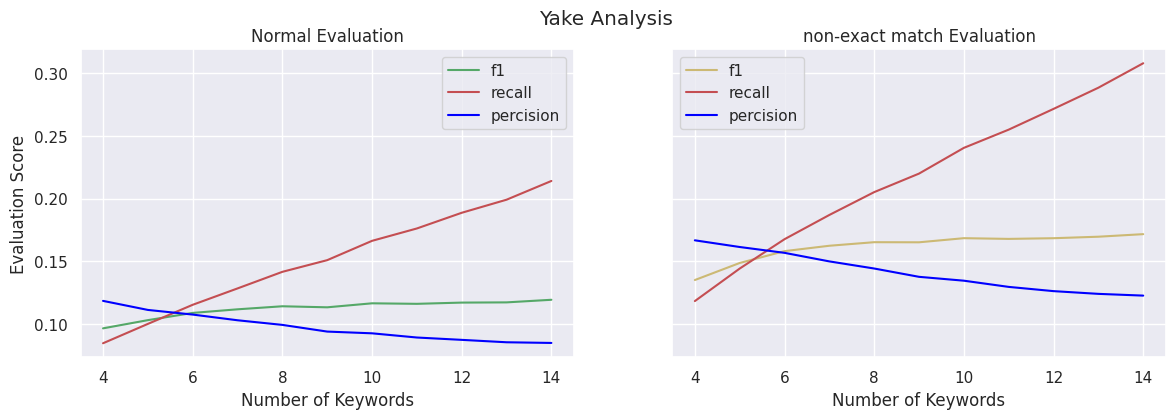

In [ ]:
fig , axes = plt.subplots(1, 2, figsize=(14, 4), sharey='row')

fig.suptitle('Yake Analysis')
axes[0].set_title('Normal Evaluation')
axes[0].set_xlabel('Number of Keywords')
axes[0].set_ylabel('Evaluation Score')
axes[0].plot(num_keys, f1_scores,label = 'f1', color='g')
axes[0].plot(num_keys, recall_scores, label='recall', color='r')
axes[0].plot(num_keys, percision_scores, label='percision', color='blue')
axes[0].legend()

axes[1].set_title('non-exact match Evaluation')
axes[1].set_xlabel('Number of Keywords')
axes[1].plot(num_keys, f1_scores_ngrams,label = 'f1', color='y')
axes[1].plot(num_keys, recall_ngrams, label='recall', color='r')
axes[1].plot(num_keys, percision_ngrams, label='percision', color='blue')
axes[1].legend()

# Embedding Rank

## SentEmbedding
#### cosine similarity between candidates and sentence using Hazm example

In [8]:
import nltk
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from hazm import SentEmbedding
from hazm import POSTagger
from hazm import Normalizer
from hazm import word_tokenize
from hazm import sent_tokenize

from sklearn.model_selection import train_test_split

In [10]:
grammers = [
    """
NP:
        {<NOUN,*>?<NOUN.*>}    # Noun(s) + Noun(optional)

""",
    """
NP:
        {<NOUN.*><ADJ.*>?}    # Noun(s) + Adjective(optional)

"""
]


# """
# NP:
#         {<NOUN.*>?<ADJ.*>?}    # Noun(s) + Adjective(optional)

# """

In [9]:
sent2vec_model_path = "./content/MyDrive/resources/Sent2Vec/sent2vec-naab.model"
sent2vec_model = SentEmbedding(sent2vec_model_path)

pos_model_path="./content/MyDrive/resources/pos_tagger.model"
tagger = POSTagger(pos_model_path)

normalizer = Normalizer()

In [ ]:
from transformers import AutoConfig, AutoTokenizer, AutoModel
# "HooshvareLab/bert-fa-base-uncased"

checkpoint = "sharif-dal/dal-bert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModel.from_pretrained(checkpoint)


In [13]:
def tokenize(text):
    return [
        word_tokenize(sent)
        for sent in sent_tokenize(normalizer.normalize(text))
    ]

def posTagger(text):
    tokens = tokenize(text)
    return tagger.tag_sents(tokens)


def extractGrammer(tagged_text, grammer):
    keyphrase_candidate = set()
    np_parser = nltk.RegexpParser(grammer)
    trees = np_parser.parse_sents(tagged_text)
    for tree in trees:
        for subtree in tree.subtrees(
            filter=lambda t: t.label() == "NP",
        ):  # For each nounphrase
            keyphrase_candidate.add(" ".join(word for word, tag in subtree.leaves()))
    keyphrase_candidate = {kp for kp in keyphrase_candidate if len(kp.split()) <= 5}
    keyphrase_candidate = list(keyphrase_candidate)
    return keyphrase_candidate


def extractCandidates(tagged_text, grammers=grammers):
    all_candidates = set()
    for grammer in grammers:
        all_candidates.update(extractGrammer(tagged_text, grammer))
    return list(all_candidates)


def text2vec(candidates, bert=False):
    # Bert tokenizer
    if bert:
      candidates_tokens = tokenizer(candidates , padding=True, return_tensors='pt')
      tokens_embeds = model(**candidates_tokens)

      candidate_vector = [[candidate[0] for candidate in tokens_embeds['last_hidden_state'].detach().numpy()]]

      sent_tokens = tokenizer(" ".join(candidates), padding=True, return_tensors='pt')
      text_vector = model(**sent_tokens)['last_hidden_state'][0][0].detach().numpy()
    else:
      candidate_vector = [[sent2vec_model[candidate] for candidate in candidates]]
      text_vector = sent2vec_model[" ".join(candidates)]

    return candidate_vector, text_vector


def vectorSimilarity(candidates_vector, text_vector, norm=True):
    candidate_sim_text = cosine_similarity(
        candidates_vector[0],
        text_vector.reshape(1, -1),
    )
    candidate_sim_candidate = cosine_similarity(candidates_vector[0])
    if norm:
        candidates_sim_text_norm = candidate_sim_text / np.max(candidate_sim_text)
        candidates_sim_text_norm = 0.5 + (
            candidates_sim_text_norm - np.average(candidates_sim_text_norm)
        ) / np.std(candidates_sim_text_norm)
        np.fill_diagonal(candidate_sim_candidate, np.NaN)
        candidate_sim_candidate_norm = candidate_sim_candidate / np.nanmax(
            candidate_sim_candidate,
            axis=0,
        )
        candidate_sim_candidate_norm = 0.5 + (
            candidate_sim_candidate_norm
            - np.nanmean(candidate_sim_candidate_norm, axis=0)
        ) / np.nanstd(candidate_sim_candidate_norm, axis=0)
        return candidates_sim_text_norm, candidate_sim_candidate_norm
    return candidate_sim_text, candidate_sim_candidate


def embedRankExtraction(
    all_candidates,
    candidate_sim_text,
    candidate_sim_candidate,
    keyword_num=10,
    beta=0.8,
    bert=False
):
    if len(all_candidates) < keyword_num:
        warnings.warn(
            (
                f"total number of keyword candidates is {len(all_candidates)}, which is"
                " lower than your request keyword_num"
            ),
        )

    N = int(min(len(all_candidates), keyword_num))

    selected_candidates = []
    unselected_candidates = list(range(len(all_candidates)))
    best_candidate = np.argmax(candidate_sim_text)
    selected_candidates.append(best_candidate)
    unselected_candidates.remove(best_candidate)

    for _i in range(N - 1):
        selected_vec = np.array(selected_candidates)
        unselected_vec = np.array(unselected_candidates)

        unselected_candidate_sim_text = candidate_sim_text[unselected_vec, :]

        dist_between = candidate_sim_candidate[unselected_vec][:, selected_vec]

        if dist_between.ndim == 1:
            dist_between = dist_between[:, np.newaxis]

        best_candidate = np.argmax(
            beta * unselected_candidate_sim_text
            - (1 - beta) * np.max(dist_between, axis=1).reshape(-1, 1),
        )
        best_index = unselected_candidates[best_candidate]
        selected_candidates.append(best_index)
        unselected_candidates.remove(best_index)

    return np.array(all_candidates)[selected_candidates].tolist()


def extractKeyword(candidates, keyword_num=5, beta=0.8, bert=False):
    candidates_vector, text_vector = text2vec(candidates)
    candidate_sim_text_norm, candidate_sim_candidate_norm = vectorSimilarity(
        candidates_vector,
        text_vector,
    )
    return embedRankExtraction(
        candidates,
        candidate_sim_text_norm,
        candidate_sim_candidate_norm,
        keyword_num,
        beta,
        bert
    )


def embedRank(text, keyword_num, bert=False, beta=0.8):
    token_tag = posTagger(text)
    candidates = extractCandidates(token_tag)
    return extractKeyword(candidates, keyword_num, beta, bert)

In [14]:
train_text, train_keywords = all_texts, df.keywords.iloc

In [ ]:
st = time.time()

betas = [0.45, 0.55, 0.65, 0.75, 0.85]
num_keywords = [4, 6, 8, 10]

scores_grid = np.zeros((len(betas), len(num_keywords)))

best_score = -1
best_params = None

for i, beta in enumerate(betas):
  for j, num in enumerate(num_keywords):
    emb_scores = []
    for t, text in enumerate(train_text):
      keywords = embedRank(text, num, beta)
      emb_scores.append(evaluate(keywords, train_keywords[t], ngrams_=True))

    score = np.array(emb_scores).mean(axis=0)[0]
    if score > best_score:
        best_score = score
        best_params = {'beta': beta, 'num_keywords': num}

    scores_grid[i, j] = score

print(f"Best Score = {round(best_score, 4)} with beta = {best_params['beta']} and \
 number of keywords = {best_params['num_keywords']}")

end = time.time()
print(f'Performance time = {round((end - st)/60, 2)} minutes')

In [46]:
scores_grid

array([[0.032646  , 0.03568072, 0.03588157, 0.03927179],
       [0.03128264, 0.03682753, 0.04052652, 0.04015508],
       [0.0292052 , 0.03613714, 0.03738245, 0.04232693],
       [0.0312837 , 0.03502204, 0.04199445, 0.03960809],
       [0.02932865, 0.03804864, 0.0434269 , 0.03882061]])

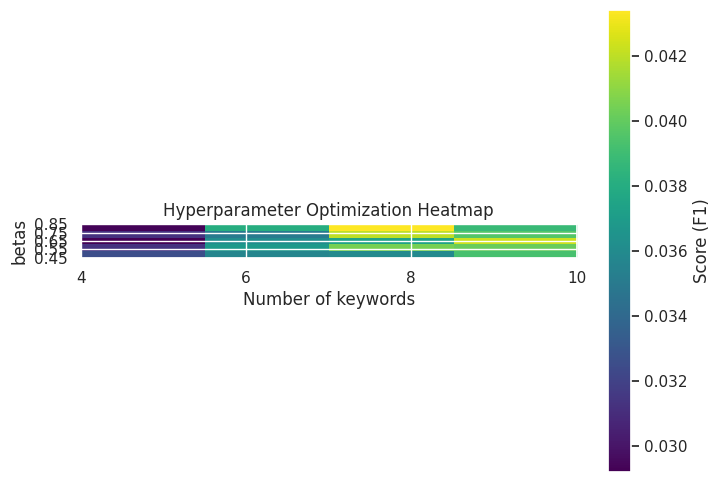

In [47]:
plt.figure(figsize=(8, 6))
plt.imshow(scores_grid, cmap='viridis', origin='lower', extent=[min(num_keywords), max(num_keywords), min(betas), max(betas)])
plt.colorbar(label='Score (F1)')
plt.xlabel('Number of keywords')
plt.ylabel('betas')
plt.title('Hyperparameter Optimization Heatmap')
plt.xticks(num_keywords)
plt.yticks(betas)
plt.show()

In [21]:
all_keyword = []
keyword_num = 10
for text in all_texts:
  keywords = embedRank(text, keyword_num, bert=True)
  all_keyword.append(keywords)

In [23]:
emb_scores = []

for i in range(len(all_keyword)):
  emb_scores.append(evaluate(all_keyword[i],df.keywords.iloc[i], ngrams_=True))

print(f'embedding f1 score with {10} keywords (BERT): ', np.array(emb_scores).mean(axis=0)[0])

embedding f1 score with 10 keywords (BERT):  0.038357646907317085


In [ ]:
del sent2vec_model

## Bert Embedding
#### Sentence Transformers and bert

In [ ]:
from keybert import KeyBERT
from sklearn.feature_extraction.text import CountVectorizer
from hazm.utils import stopwords_list


In [ ]:
stopwords = stopwords_list() + ['ها', 'های', 'ی']

bert_vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize,
                             stop_words=stopwords, analyzer='word')

In [ ]:
# kw_model = KeyBERT(model="paraphrase-multilingual-MiniLM-L12-v2")
# kw_model = KeyBERT(model="HooshvareLab/bert-fa-base-uncased")
kw_model = KeyBERT(model="sharif-dal/dal-bert")

In [ ]:
doc_embeddings, word_embeddings = kw_model.extract_embeddings(df.body.iloc[0], vectorizer=bert_vectorizer)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
text_clean = preprocess(stemming=False, lemmatizing=False, reg_clean=True, tagging=True, remove_stopwords=True)

In [ ]:
candids_raw = kw_model.extract_keywords(df.body.iloc[0], candidates=candidates, top_n=10, diversity=0.5)
# candids = kw_model.extract_keywords(text_clean, vectorizer=vectorizer, top_n=10)

In [ ]:
bert_scores_raw = []
bert_scores = []

for i in range(len(candids)):
  candids_n = [c[0] for c in candids_raw[i]]
  bert_scores_raw.append(evaluate(candids_n, df.keywords.iloc[i], ngrams_=True))

  # candids_n = [c[0] for c in candids[i]]
  # bert_scores.append(evaluate(candids_n, df.keywords.iloc[i], ngrams=True))

print(f'bert_key f1 score with {10} keywords (raw): ', np.array(bert_scores_raw).mean(axis=0)[0])
# print(f'bert_key f1 score with {10} keywords: ', np.array(bert_scores).mean(axis=0)[0])

bert_key f1 score with 10 keywords (raw):  0.10383055466990043


In [ ]:
# bert_key f1 score with 10 keywords (raw):  0.09926484607309748
# bert_key f1 score with 10 keywords:  0.0906416543253936

In [ ]:
test_candids = kw_model.extract_keywords(all_texts[:50], vectorizer=bert_vectorizer,
                                         diversity=0.75, top_n=10)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
bert_scores = []

for i in range(len(test_candids)):
  candids_n = [c[0] for c in test_candids[i]]
  bert_scores.append(evaluate(candids_n, df.keywords.iloc[i], ngrams_=False))

print(f'bert_key f1 score with {10} keywords (raw): ', np.array(bert_scores).mean(axis=0)[0])


bert_key f1 score with 10 keywords (raw):  0.08516464237516867
